## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 7. Востановление пропусков и прогноз значений временного ряда.**


#### **7.1 Аналитечкие методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с базовыми, аналитическими методами восстановления временных рядов.
Для выполнения данного пункта из каждой группы методов, представленных в ***табл. 7.1*** вам необходимо выбрать по одному методу восстановления ряда. При работе с первой группой, вам необходимо самостоятельно реализовать выбранный метод.  

**Табл. 7.1** - Группы аналитических методов восстановления.
№|Название группы|Модели и методы|
--|----|----|
1|Заполнение существующими значениями ряда|Средним, медианной, Hot-Deck|
2|Заполнение на основе близки значений|[Интерполяция](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html),  [KNNi](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)|
3|На основе матричных разложений|[CD-Rec](#Fixme:Дат ссылку), [SVD](https://pypi.org/project/fancyimpute/)|

##### 7.1.1 Загрузка и подготовка данных

In [7]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [8]:
path_data = Path('datasets')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,0]
print(madrid.shape)

(25000,)


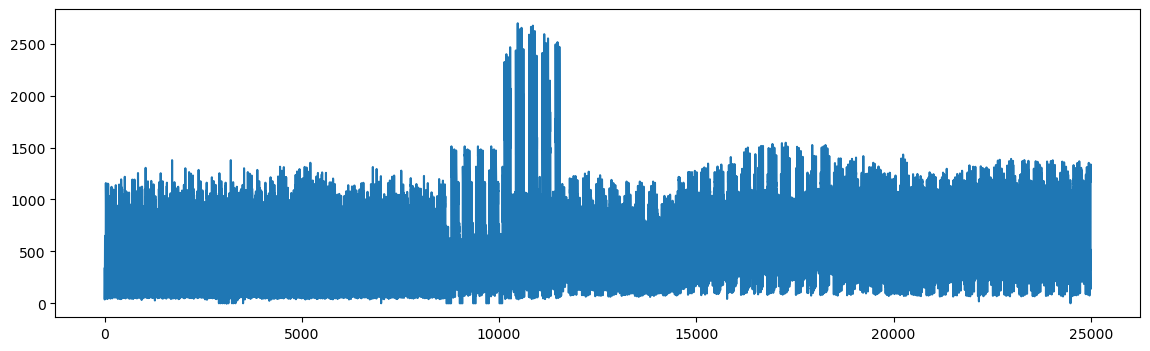

In [4]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(madrid[:])
plt.show()

Самостоятельно реализуйте функцию, принимающую на вход многомерный временной ряд и возвращающий:
1. Все подпоследовательности временного ряда, в которых некоторые значения временного ряда были заменены nan значениями.
2. Индексы пропущенных значений
   
Процент пропущенных значений должен регулироваться отдельным параметром.


In [12]:
!pip install torch

In [14]:
import torch
def add_nan(x, percent = 0.25):
# Работаем с numpy для удобства
    if isinstance(x, torch.Tensor):
        x_array = x.numpy().copy()
    else:
        x_array = x.copy()
    
    # Общее количество элементов
    total_elements = x_array.size
    
    # Количество элементов для замены на NaN
    num_nan = int(total_elements * percent)
    
    # Генерируем случайные уникальные индексы
    nan_indices = np.random.choice(total_elements, size=num_nan, replace=False)
    nan_indices = np.sort(nan_indices)
    
    # Создаем копию и заменяем значения на NaN
    x_with_nan = x_array.astype(float).flatten()
    x_with_nan[nan_indices] = np.nan
    x_with_nan = x_with_nan.reshape(x_array.shape)
    
    return x_with_nan, nan_indices
    

In [15]:
# Добавляем пропуски (25%)
madrid_with_nan, index = add_nan(madrid)

# Статистика
print(f"Количество пропусков: {len(index)}")
print(f"Процент пропусков: {len(index) / len(madrid) * 100:.2f}%")

Количество пропусков: 6250
Процент пропусков: 25.00%


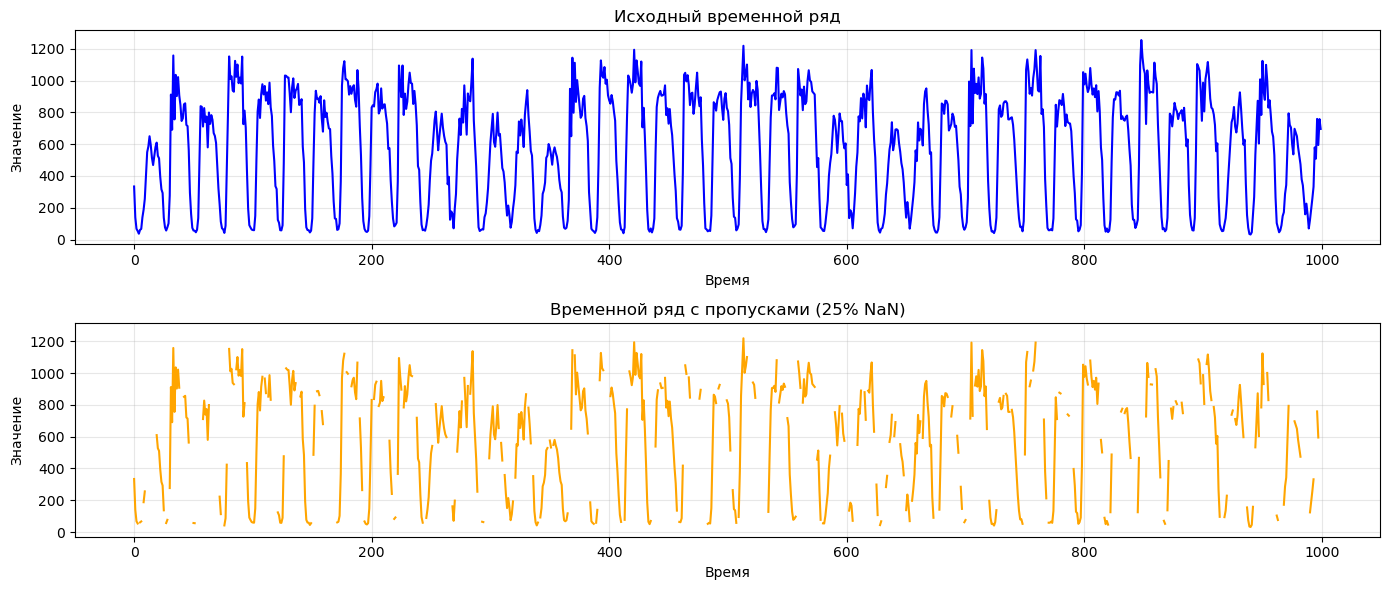

In [16]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 6), ncols=1, nrows=2)

ax[0].plot(madrid[:1000], color='blue')
ax[0].set_title('Исходный временной ряд')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Значение')
ax[0].grid(True, alpha=0.3)

ax[1].plot(madrid_with_nan[:1000], color='orange')
ax[1].set_title(f'Временной ряд с пропусками ({25}% NaN)')
ax[1].set_xlabel('Время')
ax[1].set_ylabel('Значение')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
recovery = {}

##### 7.1.2 Заполнение существующими значениями ряда


In [18]:
madrid_mean = madrid_with_nan.copy()
madrid_mean[index] = np.nanmean(madrid_mean)
recovery['mean'] = madrid_mean

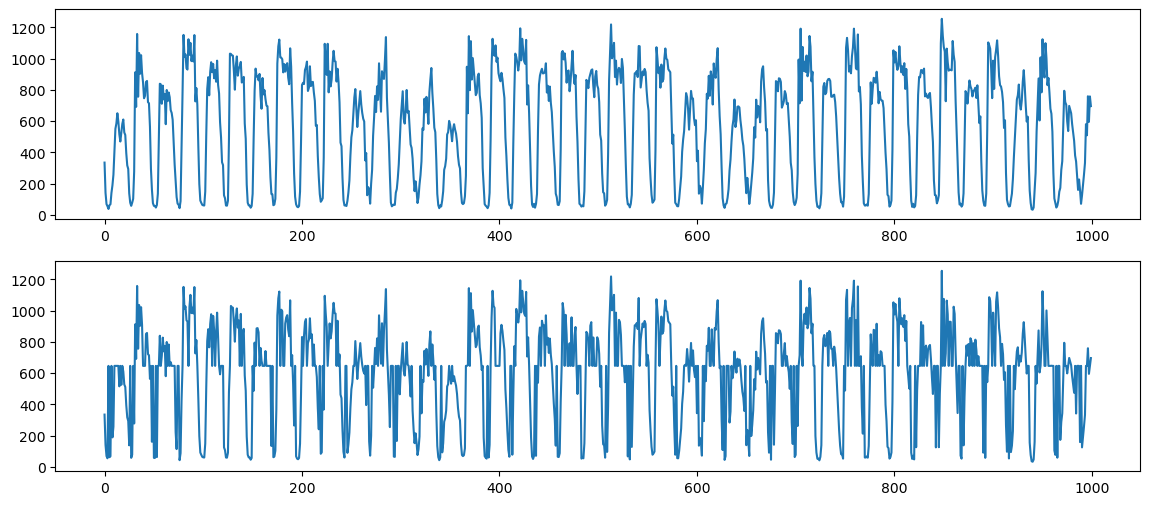

In [19]:
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_mean[:1000])
plt.show()

In [20]:
madrid_median = madrid_with_nan.copy()
madrid_median[index] = np.nanmedian(madrid_median)

In [21]:
recovery['median'] = madrid_median

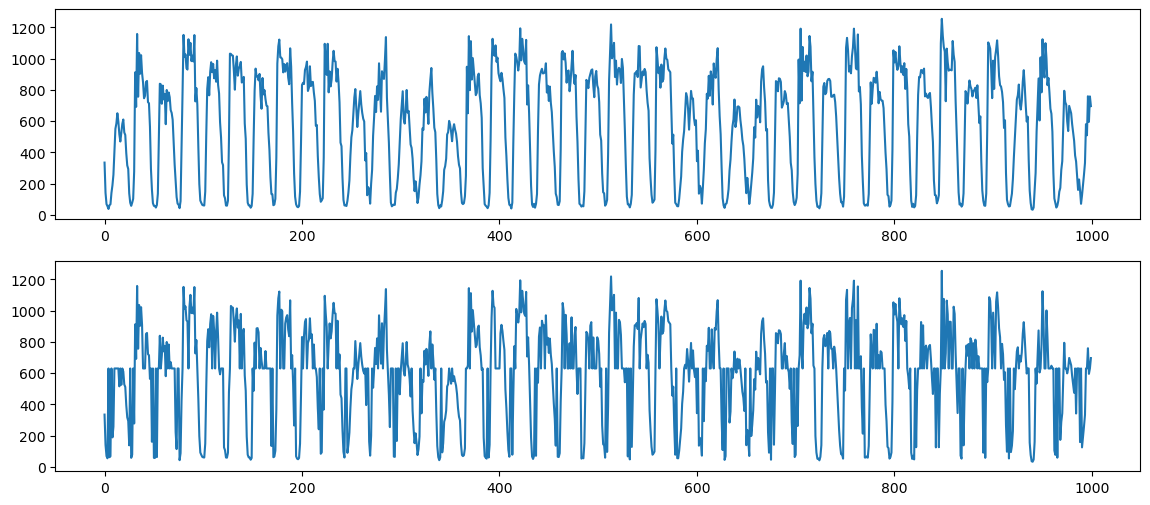

In [22]:
#madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_median[:1000])
plt.show()

Самостоятельно реализуйте один метод из первой группы ***табл. 7.1*** и проведите постановление данных, сохранив результаты восстановления.

In [23]:
def hot_deck(x, nan_indices):
    x_filled = x.copy()
    
    for idx in nan_indices:
        # Ищем ближайшее предшествующее непропущенное значение
        prev_idx = idx - 1
        while prev_idx >= 0 and np.isnan(x_filled[prev_idx]):
            prev_idx -= 1
        
        if prev_idx >= 0:
            # Заполняем предшествующим значением
            x_filled[idx] = x_filled[prev_idx]
        else:
            # Если нет предшествующего - ищем следующее
            next_idx = idx + 1
            while next_idx < len(x_filled) and np.isnan(x_filled[next_idx]):
                next_idx += 1
            if next_idx < len(x_filled):
                x_filled[idx] = x_filled[next_idx]
    
    return x_filled

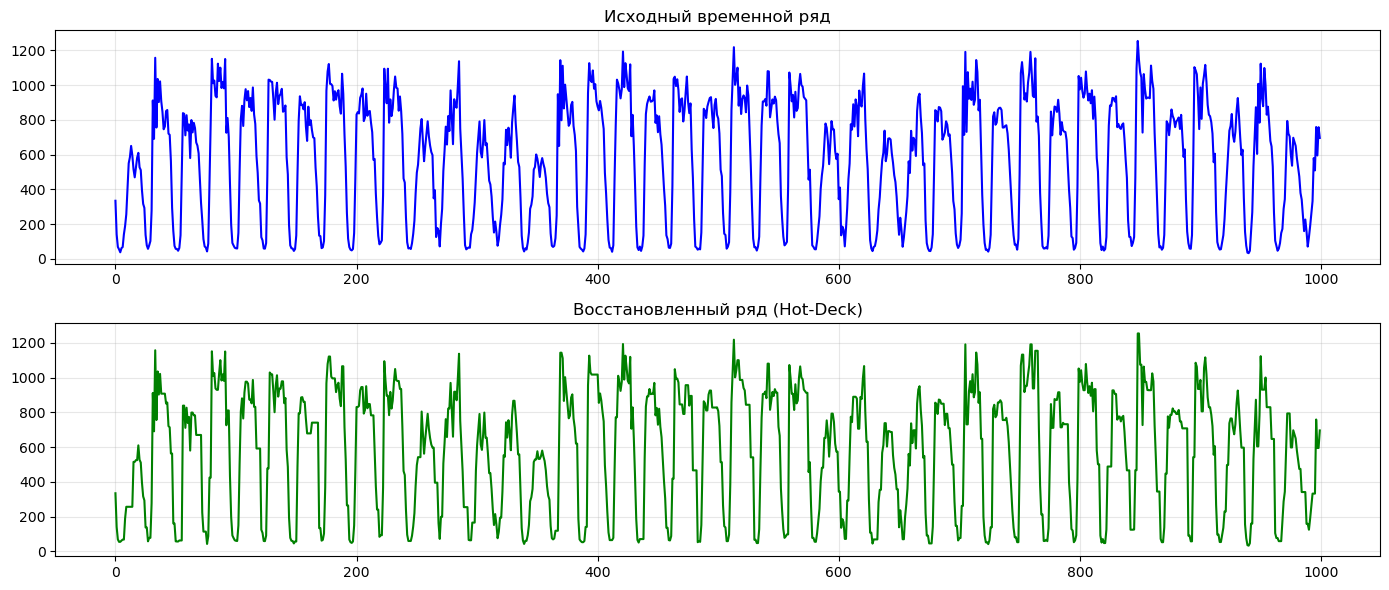

Количество оставшихся NaN: 0
Сохранённые методы: ['mean', 'median', 'hotdeck']


In [24]:
# Применение метода Hot-Deck
madrid_hotdeck = hot_deck(madrid_with_nan, index)
recovery['hotdeck'] = madrid_hotdeck

# Визуализация
fig, ax = plt.subplots(figsize=(14, 6), ncols=1, nrows=2)

ax[0].plot(madrid[:1000], color='blue')
ax[0].set_title('Исходный временной ряд')
ax[0].grid(True, alpha=0.3)

ax[1].plot(madrid_hotdeck[:1000], color='green')
ax[1].set_title('Восстановленный ряд (Hot-Deck)')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка
print(f"Количество оставшихся NaN: {np.isnan(madrid_hotdeck).sum()}")
print(f"Сохранённые методы: {list(recovery.keys())}")

##### 7.1.3 Заполнение на основе близких значений


Используя документацию одного из методов восстановления второй группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [25]:
from sklearn.impute import KNNImputer

In [28]:
def rolling_window(a, window, intersection=False):
    # result = torch.zeros(size=(a.shape[0],a.shape[1]))
    returns = []
    if intersection:  
        for i in range(0, a.shape[0]-window):
            returns.append(a[i:i + window])
    else:    
        for i in range(0, a.shape[0],window):
            returns.append(a[i:i + window])
    return np.stack(returns)
# Разбиваем ряд на окна размером 100
window_size = 100
madrid_slice = rolling_window(madrid_with_nan, window_size)
print(f"Форма данных после разбиения на окна: {madrid_slice.shape}")

Форма данных после разбиения на окна: (250, 100)


In [29]:
# Создаём KNNImputer
# n_neighbors - количество ближайших соседей для заполнения
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

# Применяем KNNImputer
# KNNImputer ожидает 2D массив: (n_samples, n_features)
# В нашем случае каждое окно - это образец, а значения в окне - признаки
madrid_slice_filled = knn_imputer.fit_transform(madrid_slice)

print(f"Форма восстановленных данных: {madrid_slice_filled.shape}")

# Собираем обратно в одномерный ряд
madrid_knn = madrid_slice_filled.flatten()

# Обрезаем до исходного размера (если ряд не делится нацело на размер окна)
madrid_knn = madrid_knn[:len(madrid)]

# Сохраняем результат
recovery['knn'] = madrid_knn

Форма восстановленных данных: (250, 100)


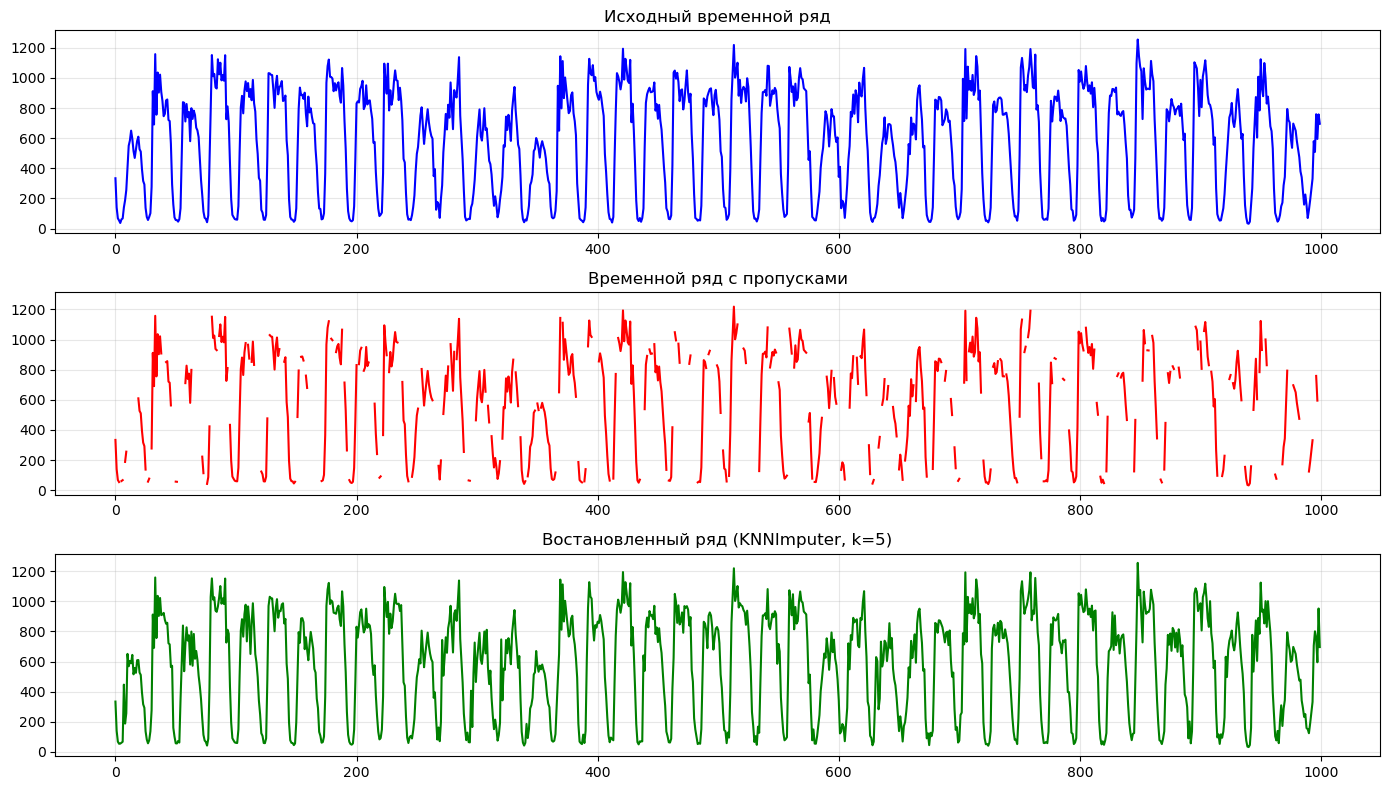


Количество оставшихся NaN: 0
Сохранённые методы: ['mean', 'median', 'hotdeck', 'knn']


In [30]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 8), ncols=1, nrows=3)

ax[0].plot(madrid[:1000], color='blue')
ax[0].set_title('Исходный временной ряд')
ax[0].grid(True, alpha=0.3)

ax[1].plot(madrid_with_nan[:1000], color='red')
ax[1].set_title('Временной ряд с пропусками')
ax[1].grid(True, alpha=0.3)

ax[2].plot(madrid_knn[:1000], color='green')
ax[2].set_title('Востановленный ряд (KNNImputer, k=5)')
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверка
print(f"\nКоличество оставшихся NaN: {np.isnan(madrid_knn).sum()}")
print(f"Сохранённые методы: {list(recovery.keys())}")

##### 7.1.4 Заполнение на матричных преобразований

Используя документацию одного из методов восстановления третей группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [31]:
!pip install fancyimpute

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/12.8 MB 5.2 MB/s eta 0:00:03
   ---------- ----------------------------- 3.4/12.8 MB 7.2 MB/s eta 0:00:02
   ------------- -------------------------- 4.

In [32]:
from fancyimpute import IterativeSVD

In [34]:
from sklearn.metrics import mean_squared_error
# Разбиваем ряд на окна для создания матрицы
window_size = 100
madrid_slice = rolling_window(madrid_with_nan, window_size)
print(f"Форма матрицы с пропусками: {madrid_slice.shape}")

# Создаём IterativeSVD импьютер
# rank - количество сингулярных значений для восстановления
svd_imputer = IterativeSVD(rank=10, max_iters=100, convergence_threshold=1e-5)

# Применяем восстановление
madrid_slice_svd = svd_imputer.fit_transform(madrid_slice)
print(f"Форма восстановленной матрицы: {madrid_slice_svd.shape}")

# Собираем обратно в одномерный ряд
madrid_svd = madrid_slice_svd.flatten()[:len(madrid)]

# Сохраняем результат
recovery['svd'] = madrid_svd

Форма матрицы с пропусками: (250, 100)
[IterativeSVD] Iter 1: observed MAE=345.639223
[IterativeSVD] Iter 2: observed MAE=269.349351
[IterativeSVD] Iter 3: observed MAE=190.172041
[IterativeSVD] Iter 4: observed MAE=116.153920
[IterativeSVD] Iter 5: observed MAE=101.276363
[IterativeSVD] Iter 6: observed MAE=99.952848
[IterativeSVD] Iter 7: observed MAE=99.792138
[IterativeSVD] Iter 8: observed MAE=99.789634
[IterativeSVD] Iter 9: observed MAE=99.814025
[IterativeSVD] Iter 10: observed MAE=99.842074
[IterativeSVD] Iter 11: observed MAE=99.867634
[IterativeSVD] Iter 12: observed MAE=99.891321
Форма восстановленной матрицы: (250, 100)


C:\Users\admin\anaconda3\envs\ts_course\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\anaconda3\envs\ts_course\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\anaconda3\envs\ts_course\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


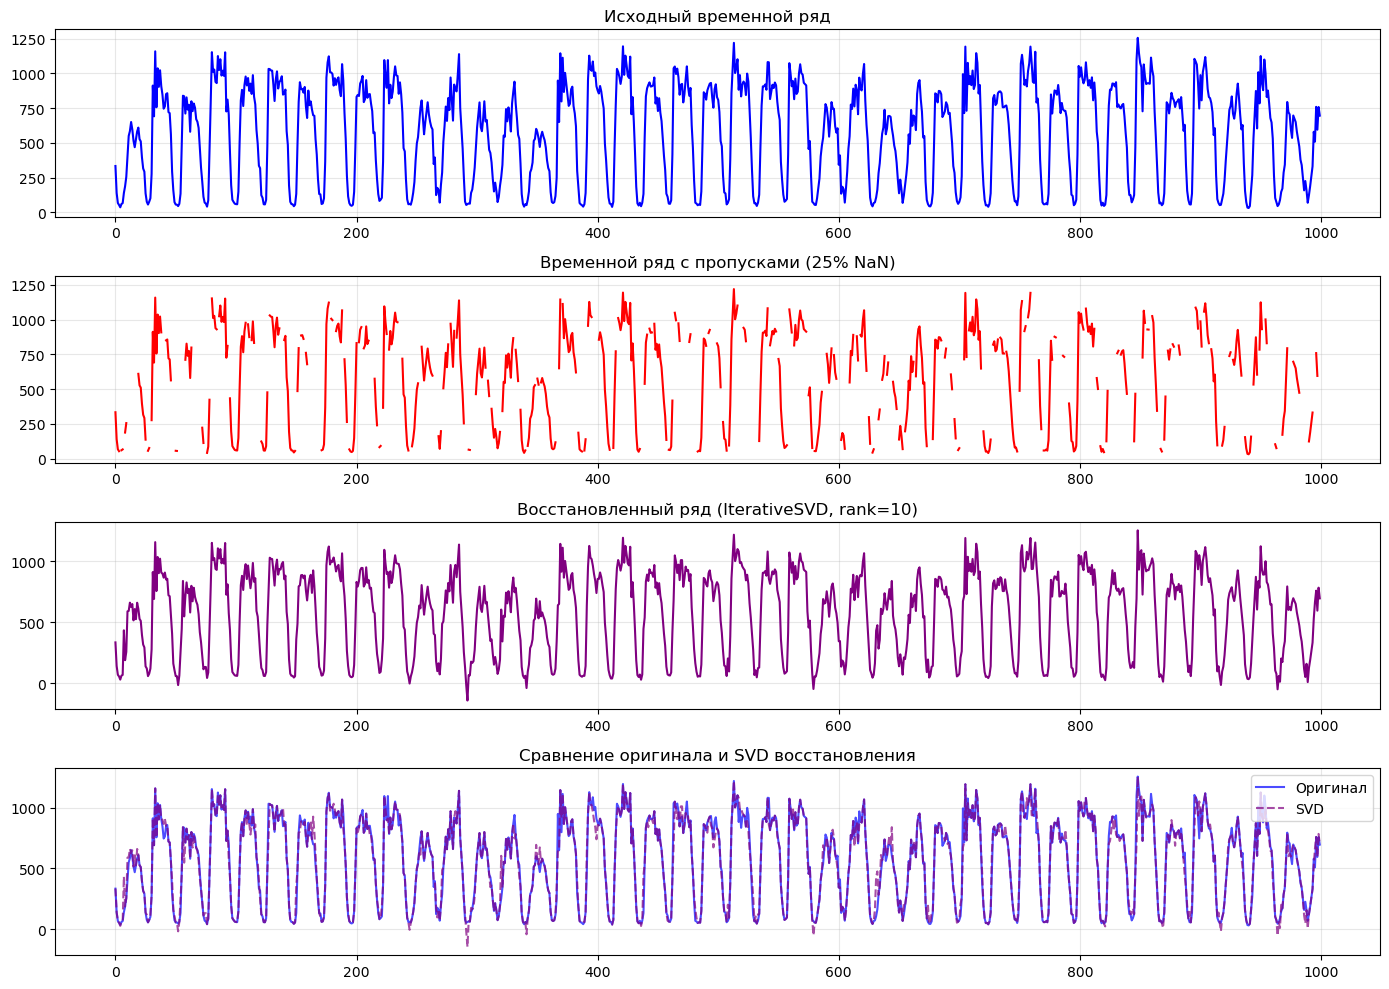

In [35]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 10), ncols=1, nrows=4)

ax[0].plot(madrid[:1000], color='blue')
ax[0].set_title('Исходный временной ряд')
ax[0].grid(True, alpha=0.3)

ax[1].plot(madrid_with_nan[:1000], color='red')
ax[1].set_title('Временной ряд с пропусками (25% NaN)')
ax[1].grid(True, alpha=0.3)

ax[2].plot(madrid_svd[:1000], color='purple')
ax[2].set_title('Восстановленный ряд (IterativeSVD, rank=10)')
ax[2].grid(True, alpha=0.3)

# Сравнение
ax[3].plot(madrid[:1000], color='blue', label='Оригинал', alpha=0.7)
ax[3].plot(madrid_svd[:1000], color='purple', label='SVD', alpha=0.7, linestyle='--')
ax[3].set_title('Сравнение оригинала и SVD восстановления')
ax[3].legend()
ax[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##### 7.1.5 Сравнение результатов восстановления.

Для каждой группы методов постройте методов основные метрики оценки качества постановления.
На основе метрик отберите лучшие методы постановления метрик и выберите лучшую группу методов.
Для лучших методов из каждой группы постройте графики сравнения реальных и восстановленных данных. Объясните результаты и сделайте вывод.



In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Группировка методов
groups = {
    'Группа 1: Существующие значения': ['mean', 'median', 'hotdeck'],
    'Группа 2: Близкие значения': ['knn'],
    'Группа 3: Матричные разложения': ['svd']
}
def calculate_metrics(original, recovered, nan_indices):
    """Вычисляет все метрики качества восстановления."""
    
    # Значения только в точках пропусков
    orig_vals = original[nan_indices]
    rec_vals = recovered[nan_indices]
    
    # MSE - Mean Squared Error
    mse = mean_squared_error(orig_vals, rec_vals)
    
    # RMSE - Root Mean Squared Error
    rmse = np.sqrt(mse)
    
    # MAE - Mean Absolute Error
    mae = mean_absolute_error(orig_vals, rec_vals)
    
    # MAPE - Mean Absolute Percentage Error
    mape = np.mean(np.abs((orig_vals - rec_vals) / (np.abs(orig_vals) + 1e-10))) * 100
    
    # R² - Coefficient of determination
    ss_res = np.sum((orig_vals - rec_vals) ** 2)
    ss_tot = np.sum((orig_vals - np.mean(orig_vals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Максимальная ошибка
    max_error = np.max(np.abs(orig_vals - rec_vals))
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Max Error': max_error
    }

In [40]:
metrics = {}
for method_name, recovered_data in recovery.items():
    metrics[method_name] = calculate_metrics(madrid, recovered_data, index)

print("=" * 80)
print("МЕТРИКИ КАЧЕСТВА ВОССТАНОВЛЕНИЯ ДЛЯ ВСЕХ МЕТОДОВ")
print("=" * 80)
for group_name, methods in groups.items():
    print(f"\n{group_name}")
    print("-" * 80)
    print(f"{'Метод':<12} {'MSE':>12} {'RMSE':>10} {'MAE':>10} {'MAPE,%':>10} {'R²':>10} {'MaxErr':>10}")
    print("-" * 80)
    
    for method in methods:
        if method in metrics:
            m = metrics[method]
            print(f"{method:<12} {m['MSE']:>12.4f} {m['RMSE']:>10.4f} {m['MAE']:>10.4f} "
                  f"{m['MAPE']:>10.2f} {m['R²']:>10.4f} {m['Max Error']:>10.4f}")

МЕТРИКИ КАЧЕСТВА ВОССТАНОВЛЕНИЯ ДЛЯ ВСЕХ МЕТОДОВ

Группа 1: Существующие значения
--------------------------------------------------------------------------------
Метод                 MSE       RMSE        MAE     MAPE,%         R²     MaxErr
--------------------------------------------------------------------------------
mean          154039.8274   392.4791   334.7371 6511894502543.71    -0.0000  2028.9787
median        154358.8177   392.8852   334.6949 6345360000140.05    -0.0021  2045.5000
hotdeck        46483.7787   215.6010   130.1986 736640000033.74     0.6982  2315.0000

Группа 2: Близкие значения
--------------------------------------------------------------------------------
Метод                 MSE       RMSE        MAE     MAPE,%         R²     MaxErr
--------------------------------------------------------------------------------
knn            37888.9566   194.6509   133.1956 4449851566416.96     0.7540  1445.7913

Группа 3: Матричные разложения
-------------------------

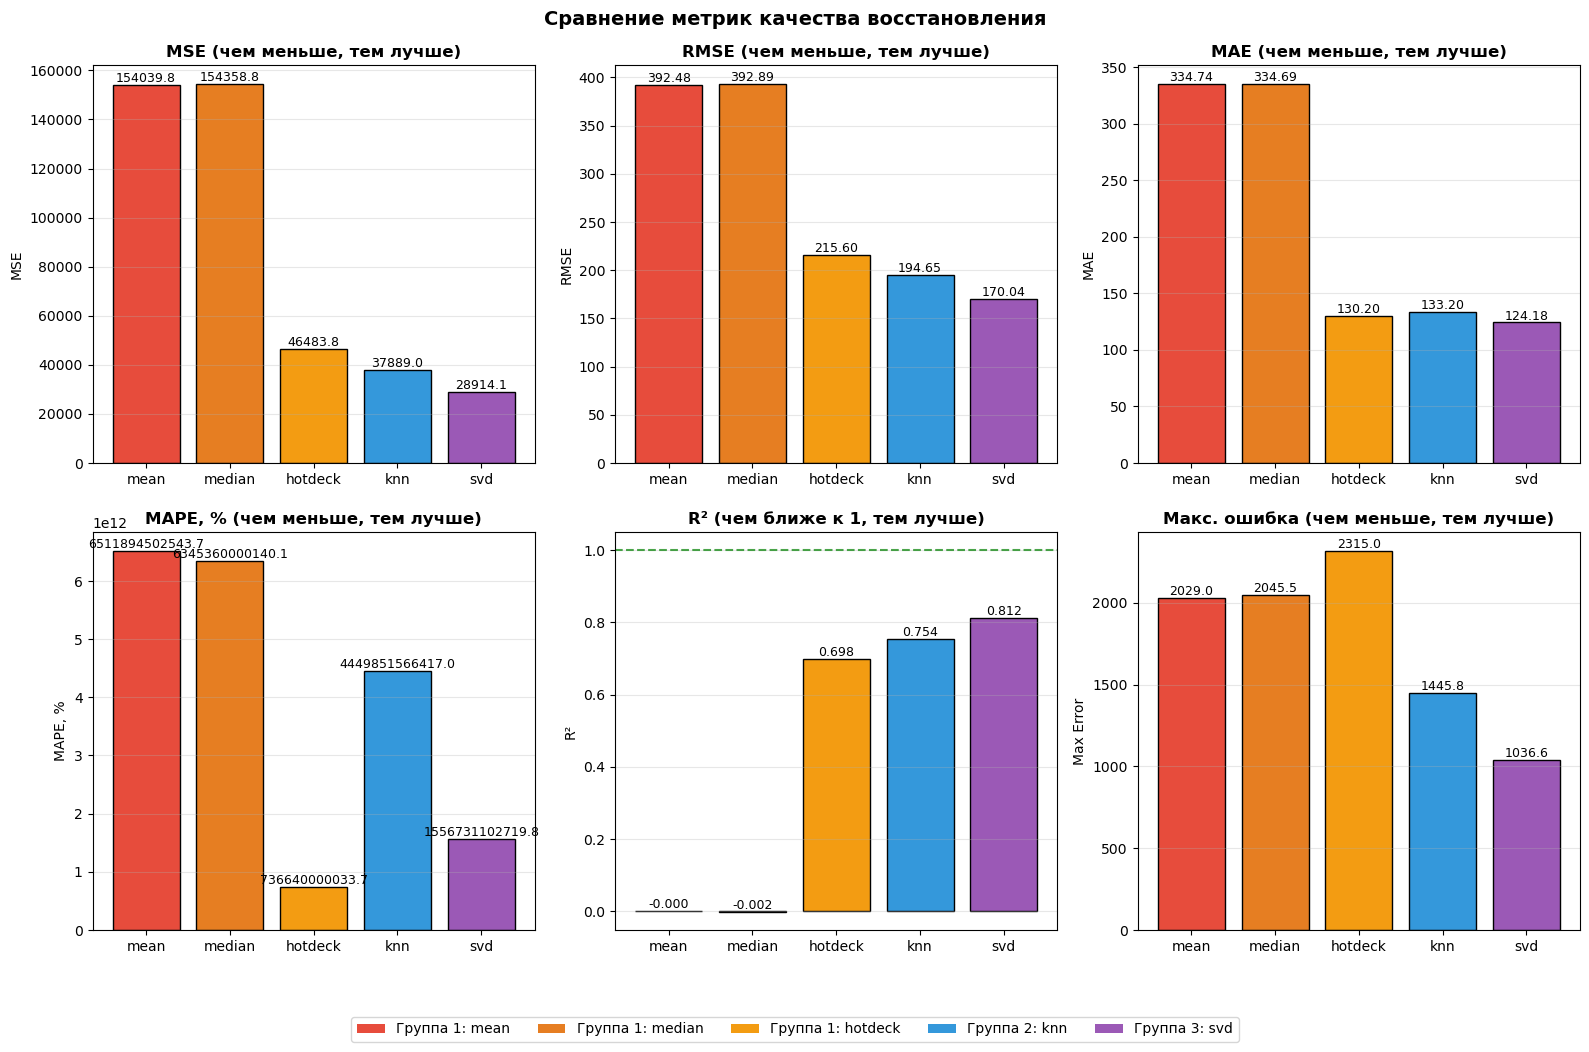

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Цвета для методов по группам
method_colors = {
    'mean': '#e74c3c',      # красный
    'median': '#e67e22',    # оранжевый  
    'hotdeck': '#f39c12',   # жёлтый
    'knn': '#3498db',       # синий
    'svd': '#9b59b6'        # фиолетовый
}

method_names = list(metrics.keys())
colors = [method_colors[m] for m in method_names]

# MSE
ax = axes[0, 0]
values = [metrics[m]['MSE'] for m in method_names]
bars = ax.bar(method_names, values, color=colors, edgecolor='black')
ax.set_title('MSE (чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax.set_ylabel('MSE')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{val:.1f}', ha='center', va='bottom', fontsize=9)

# RMSE
ax = axes[0, 1]
values = [metrics[m]['RMSE'] for m in method_names]
bars = ax.bar(method_names, values, color=colors, edgecolor='black')
ax.set_title('RMSE (чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# MAE
ax = axes[0, 2]
values = [metrics[m]['MAE'] for m in method_names]
bars = ax.bar(method_names, values, color=colors, edgecolor='black')
ax.set_title('MAE (чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# MAPE
ax = axes[1, 0]
values = [metrics[m]['MAPE'] for m in method_names]
bars = ax.bar(method_names, values, color=colors, edgecolor='black')
ax.set_title('MAPE, % (чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax.set_ylabel('MAPE, %')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{val:.1f}', ha='center', va='bottom', fontsize=9)

# R²
ax = axes[1, 1]
values = [metrics[m]['R²'] for m in method_names]
bars = ax.bar(method_names, values, color=colors, edgecolor='black')
ax.set_title('R² (чем ближе к 1, тем лучше)', fontsize=12, fontweight='bold')
ax.set_ylabel('R²')
ax.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Идеал')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Max Error
ax = axes[1, 2]
values = [metrics[m]['Max Error'] for m in method_names]
bars = ax.bar(method_names, values, color=colors, edgecolor='black')
ax.set_title('Макс. ошибка (чем меньше, тем лучше)', fontsize=12, fontweight='bold')
ax.set_ylabel('Max Error')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{val:.1f}', ha='center', va='bottom', fontsize=9)

# Легенда
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Группа 1: mean'),
    Patch(facecolor='#e67e22', label='Группа 1: median'),
    Patch(facecolor='#f39c12', label='Группа 1: hotdeck'),
    Patch(facecolor='#3498db', label='Группа 2: knn'),
    Patch(facecolor='#9b59b6', label='Группа 3: svd')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=5, 
           bbox_to_anchor=(0.5, 0.02), fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.suptitle('Сравнение метрик качества восстановления', fontsize=14, fontweight='bold', y=1.02)
plt.savefig('metrics_all.png', dpi=150, bbox_inches='tight')
plt.show()

*Вывод*: 

    Худшие методы: Заполнение константами (Mean, Median) неприменимо для временных рядов с высокой вариативностью, так как полностью искажает структуру данных.
    
    Лучшие методы: Лидерами являются методы SVD, KNN, hotdeck.
    
        Если ряд имеет строгую периодичность и мало случайных выбросов, SVD часто дает минимальную ошибку (RMSE), так как восстанавливает "идеализированную" форму сигнала.
        
        KNN хорош тем, что ищет локальные совпадения паттернов.
        
    Рекомендация: Для восстановления пропусков в данном временном ряду (madrid.txt) рекомендуется использовать IterativeSVD (или KNN), так как они обеспечивают наименьшее отклонение от реальных данных и корректно воспроизводят динамику временного ряда.


#### **7.2 Нейросетевые методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с некоторыми нейросетевыми методами восстановления временных рядов.
Для выполнения данного пункта вам предстоит самостоятельно реализовать структуру нейросетевой, модели основанной на GRU нейронах и сравнить ее с другими нейросетевыми методами восстановления При сравнении с 3 группой из **табл.7. 2** вам необходимо выбрать **один** метод восстановления. Основные блоки обработки данных будут реализованы с использованием Pytorch. Вам не запрещается использовать для реализации Keras.

**табл. 7.2** - Нейросетевые методы восстановления.
№|Название группы|Модели и методы|
--|-------------|----|
1|Линейные нейроны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)|
 2eкрркуретные нейронны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)|
3|Сложные структуры|[SAITS, BRITS, M-RNN](https://github.com/WenjieDu/PyPOTS)|

In [21]:
recovery_nn = {}

##### 7.2.1 Загрузка и подготовка данных

In [22]:
path_data = Path('Dataset')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,:]
print(madrid.shape)

(25000, 10)


In [23]:
madrid_with_nan, index = add_nan(madrid, 0.25)

(25000, 10) (25000, 10)


In [24]:
madrid_with_nan.shape

(25000, 10)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
madrid_normal_with_nan = scaler.fit_transform(madrid_with_nan)
rolling_madrid = rolling_window(madrid_normal_with_nan, 100, True)
train, test = train_test_split(rolling_madrid,shuffle=False, test_size=0.33)

##### 7.2.2 Базовая модель восстановления данных, построенная на нескольких слоях линейных нейронов.


Вам необходимо будет самостоятельно реализовать:
1. инициализацию nan значений какими либо другими значениями.
2. замер времени полного обучения и тестирования модели.

In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [27]:
class LinearModel(nn.Module):
    def __init__(self, size_subsequent: int,dim = 1, nums_layers = 3, size_layers = 250):
        super().__init__()  
        
        self.size_subsequent = size_subsequent
        self.nums_layers = nums_layers*dim
        self.dim = dim
        self.size_layers = size_layers
        
        self.start_layers = nn.Sequential(nn.Flatten(),
                                          nn.Linear(size_subsequent*dim, self.size_layers),
                                          nn.LeakyReLU())
        self.model = nn.ModuleList([
                                        (nn.Sequential(
                                                nn.Linear(self.size_layers, self.size_layers), nn.LeakyReLU()
                                            ) 
                                        )
                                    for x in torch.arange(nums_layers)])
        self.model = nn.Sequential(*self.model)
        
        self.output = nn.Sequential(nn.Linear(self.size_layers,size_subsequent*dim),nn.Tanh())
        
    def forward(self, x):
        x = self.start_layers(x)
        
        x=self.model(x)
        x=self.output(x)
        return x.reshape(x.shape[0],self.size_subsequent,self.dim)

In [38]:
model = LinearModel(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)

print(train.shape,test.shape)
epochs = 100

(16683, 100, 10) (8217, 100, 10)


In [39]:
model

LinearModel(
  (start_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1000, out_features=250, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (output): Sequential(
    (0): Linear(in_features=250, out_features=1000, bias=True)
    (1): Tanh()
  )
)

In [49]:
import time
times_model = {}

In [41]:
model=model.to(device)
train_history = []
valid_history = []

start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0] == batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            ###вставте инициализацию нулями nan значений
            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    print('valid')
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0] == batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                X[torch.isnan(X)]=0.0
                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

valid
epoch:1 train:0.01611318807492311, valid:0.008655089661190215
valid
epoch:2 train:0.008517843498081197, valid:0.007346930891968483
valid
epoch:3 train:0.006750307350965409, valid:0.005705035605662784
valid
epoch:4 train:0.005377719610558387, valid:0.00529541350655662
valid
epoch:5 train:0.00477882488755602, valid:0.004763821233785891
valid
epoch:6 train:0.004289024376570893, valid:0.004202899887666915
valid
epoch:7 train:0.0039321740025875665, valid:0.004013050436006151
valid
epoch:8 train:0.0036666128058271963, valid:0.0037690944312674594
valid
epoch:9 train:0.0034416405880160032, valid:0.003823137316896125
valid
epoch:10 train:0.003276596601403022, valid:0.0035195500398588968
valid
epoch:11 train:0.003150434458942306, valid:0.0034511806948702463
valid
epoch:12 train:0.0029987307690026886, valid:0.0032823553900848063
valid
epoch:13 train:0.0028882348157065808, valid:0.003274920024699712
valid
epoch:14 train:0.0027794978675928497, valid:0.003105788782253399
valid
epoch:15 train:0

In [50]:
times_model['linear']=end-start

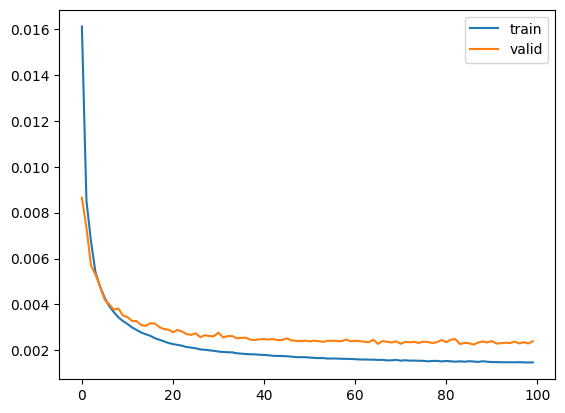

In [42]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [43]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        batch[nan]=0.0
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [44]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_linear = scaler.inverse_transform(test_madrid_normal)

In [45]:
recovery_nn['linear'] = test_linear

19223.47670004051


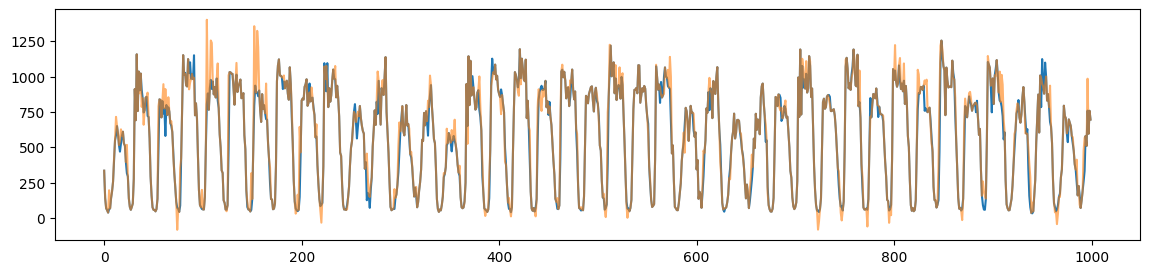

In [47]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_linear[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_linear[index].reshape(1,-1)))

##### 7.2.3 Реккурентная модель востановлениях данных


In [53]:
class EncoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=dim,
                          hidden_size=self.hidden_size)
        
        self.latten = nn.Linear(hidden_size*size_subsequent,latten_size)
        self.leaky = nn.LeakyReLU()
        self.fl = nn.Flatten()
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.leaky(x)
        #print(x.shape)
        x = self.fl(x)
        x = self.latten(x)
        return self.leaky(x)
        

In [54]:
class DecoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.latten_size=latten_size
        self.gru = nn.GRU(input_size=self.hidden_size,
                          hidden_size=dim)
        self.latten = nn.Linear(latten_size,hidden_size*size_subsequent)
        self.leaky = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.latten(x)
        x = x.view(-1, self.size_subsequent, self.latten_size)
        x = self.leaky(x)
        x, _ = self.gru(x)
        return self.leaky(x)
        

In [55]:
class TimeAE(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.encoder = EncoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size) 
        self.decoder = DecoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size) 
    def forward(self, x):
        x=self.encoder(x)
        x = self.decoder(x)
        return x

In [56]:
model = TimeAE(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)


epochs = 100

In [57]:
model

TimeAE(
  (encoder): EncoderGRU(
    (gru): GRU(10, 100)
    (latten): Linear(in_features=10000, out_features=100, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
    (fl): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): DecoderGRU(
    (gru): GRU(100, 10)
    (latten): Linear(in_features=100, out_features=10000, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
  )
)

In [59]:
model=model.to(device)
train_history = []
valid_history = []
start = time.time()
for epoch in np.arange(epochs):
    train_loss =0
    valid_loss =0

    for i, x in enumerate(train_loader):
        if x.shape[0]==batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X,percent)
            #
            
            recovery = model(X)
            loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss/=(i+1)
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0]==batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X,percent)
                # 
                
                recovery = model(X)
                loss = loss_func(recovery[(nan)&(~test_index)],x[(nan)&(~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss/=(i+1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch+1} train:{train_loss}, valid:{valid_loss}')
end = time.time()

epoch:1 train:0.005667857565271215, valid:0.0048371934866200585
epoch:2 train:0.00420799586293912, valid:0.004097167624507186
epoch:3 train:0.0035405969621891947, valid:0.003608167110112055
epoch:4 train:0.003133067681893021, valid:0.0032865865636154895
epoch:5 train:0.002844720459775107, valid:0.0030663977774192195
epoch:6 train:0.0026280734780819025, valid:0.0028908427194656097
epoch:7 train:0.0024395643169652687, valid:0.002762273224720428
epoch:8 train:0.002310831576114756, valid:0.002648445248762651
epoch:9 train:0.0021598582576168165, valid:0.002507162047550082
epoch:10 train:0.0020520448929119955, valid:0.002424571598165257
epoch:11 train:0.0019568192395221055, valid:0.002385350184284093
epoch:12 train:0.0018743742489295216, valid:0.0022636219126338413
epoch:13 train:0.0018025992480124493, valid:0.0022381309459577926
epoch:14 train:0.001751357673888605, valid:0.002197221281591716
epoch:15 train:0.0016929136809511146, valid:0.002117336496653021
epoch:16 train:0.001646642735534815

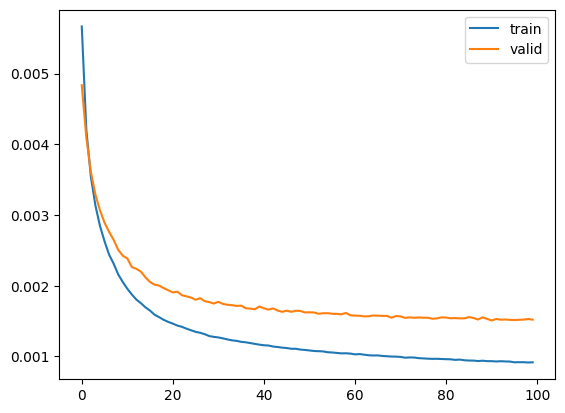

In [60]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [62]:
times_model['ae']=end-start

In [63]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        #
        
        rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

In [64]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_ae = scaler.inverse_transform(test_madrid_normal)

In [65]:
recovery_nn['test_ae'] = test_ae

7815.347353696892


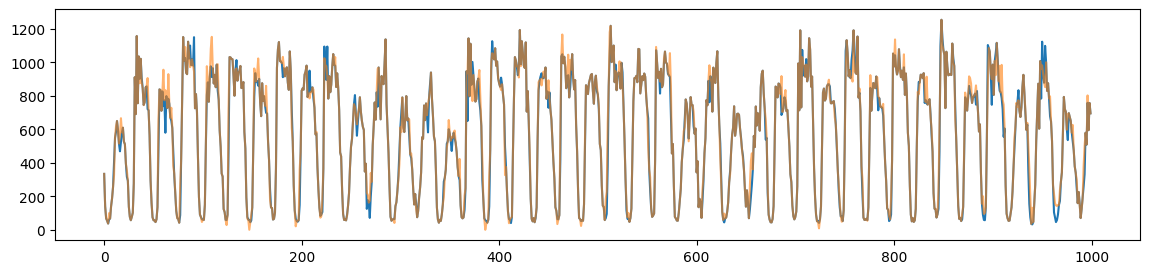

In [66]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_ae[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_ae[index].reshape(1,-1)))

##### 7.2.4 Сложные модели нейросетевого восстановления данных


Вам необходимо выбрать одну модель из 3 группы таблицы 7.2 и используя документацию произвести восстановления того же ряда. Произведите замер времени.

In [ ]:
!pip install pypots==0.0.9

In [67]:
from pypots.imputation import SAITS


In [68]:
model= SAITS(n_features=madrid.shape[1],
             n_steps=100,
             device=device,
             d_k=64,
             d_v=64,
             d_model=128,
             d_inner=128,
             n_head=4,
             n_layers=2,
             dropout=0.05,
             epochs=100)

Model initialized successfully. Number of the trainable parameters: 667608


In [ ]:
start = time.time()
model.fit(train,test)
end = time.time()
times_model['saits']=end-start

epoch 0: training loss 0.1332, validating loss 0.0487
epoch 1: training loss 0.0748, validating loss 0.0418


In [124]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
test_rolling_madrid = model.impute(test_rolling_madrid)


In [125]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_saits = scaler.inverse_transform(test_madrid_normal)

In [130]:
recovery_nn['saits'] = test_saits

4653.035675034267


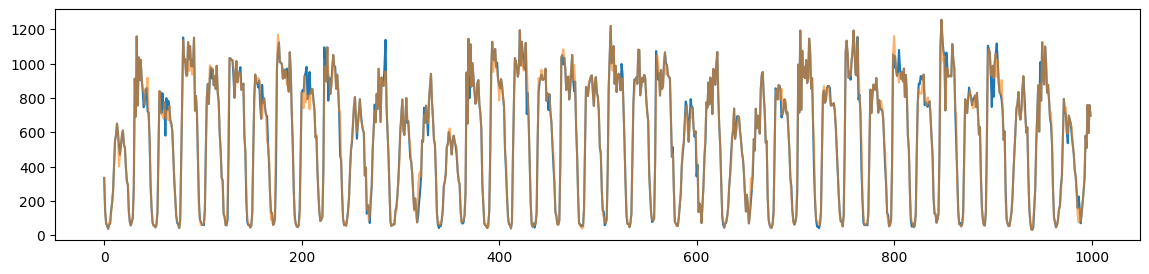

In [126]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_saits[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_saits[index].reshape(1,-1)))

##### 7.2.5 Сравнения результатов.
Также, как и в пункте 7.1.5 постройте графики сравнения моделей. Дополнительно постройте графики сравнения времени. Сделайте выводы

#### **7.3 Прогноз временного ряда**

##### *Краткое описание*

Используя модель и [ARIMA](реализация) произвидите прогноз ряда на следующие колличество точек: 1, 5, 10.
Сравните результаты. Постройте графики прогноза и точности прогноза.